## Premise

Generate a dataset that follows a simple system of ODEs using interative calculations. Then train a neural network to fit the dataset

##### System of ODE:

$\frac{\mathrm{d}x}{\mathrm{d}t} = \sigma (y - x), \\[6pt]$


$\frac{\mathrm{d}y}{\mathrm{d}t} = x (\rho - z) - y, \\[6pt]$


$\frac{\mathrm{d}z}{\mathrm{d}t} = x y - \beta z.$

$σ'' = 10$, $β = 8/3$ and $ρ = 28$

## Neural Network Model

Implemented using Pytorch Lightning model. I'm lazy and do not want to manually implement training and epoch loops :3.

In [36]:
import torch, torch.nn as nn, torch.utils.data as data, torchvision as tv, torch.nn.functional as F
import lightning as L
import numpy as np


class Learner(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 50),
            nn.ELU(),
            nn.Linear(50, 100),
            nn.ELU(),
            nn.Linear(100, 100),
            nn.ELU(),
            nn.Linear(100, 100),
            nn.ELU(),
            nn.Linear(100, 100),
            nn.ELU(),
            nn.Linear(100, 100),
            nn.ELU(),
            nn.Linear(100, 100),
            nn.ELU(),
            nn.Linear(100, 50),
            nn.ELU(),
            nn.Linear(50, 3),
        )

    def forward(self, input):
        return self.model(input)

    def training_step(self, batch, batch_idx):
        t, xyz = batch
        xyz_predicted = self.model(t)

        loss = nn.MSELoss()(xyz, xyz_predicted)

        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        return optimizer

## Dataset Generation

Implemented using torch.data.Dataset. The data is generated by iteratively generating the function by calculating small increments of dx and dy.

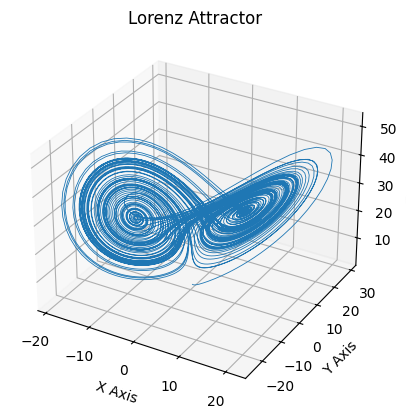

In [29]:
import matplotlib.pyplot as plt


def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s * (y - x)
    y_dot = r * x - y - x * z
    z_dot = x * y - b * z
    return np.array([x_dot, y_dot, z_dot])


dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = [0.0, 1.0, 1.05]  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# Plot
ax = plt.figure().add_subplot(projection="3d")

ax.plot(*xyzs.T, lw=0.6)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [30]:
class LorenzDataset(data.Dataset):

    def __init__(self, t, xyz, n):
        self.n = n
        self.t = t
        self.xyz = xyz

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        t = self.t[idx, np.newaxis]
        xyz = self.xyz[idx]

        return torch.Tensor(t).to("cuda"), torch.Tensor(xyz).to("cuda")

In [32]:
train = LorenzDataset(torch.linspace(0, 100.01, 10001), xyzs, 10001)

## Training

In [33]:
# C:\Users\zheyu\AppData\Local\Programs\Python\Python312\Scripts
print(torch.version.cuda)

11.8


In [37]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import timeit

start_time = timeit.default_timer()

early_stop_callback = EarlyStopping(
    monitor="train_loss",
    min_delta=0.00,
    patience=10000,
    verbose=False,
    mode="min",
    stopping_threshold=0.1,
)
trainer = L.Trainer(
    accelerator="cuda", logger=False, max_epochs=10000, callbacks=[early_stop_callback]
)
learner = Learner()
trainer.fit(learner, data.DataLoader(train, batch_size=1000))

print("Time Elapse: ", timeit.default_timer() - start_time)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 862 K 
-------------------------------------
862 K     Trainable params
0         Non-trainable params
862 K     Total params
3.450     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Time Elapse:  5783.2496291999705


## Evaluating Predictions

In [40]:
xyz_pred = learner.model.forward(train.t.view(10001, 1).to("cuda"))

<Figure size 1000x500 with 0 Axes>

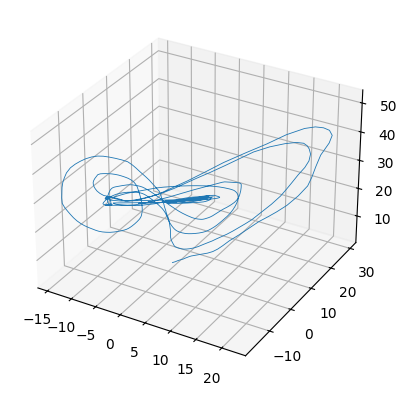

In [43]:
fig = plt.figure(figsize=(10, 5))
ax = plt.figure().add_subplot(projection="3d")

ax.plot(*xyz_pred.cpu().detach().T, lw=0.6)